# K-means Clustering and Principal Component Analysis

## 1 K-means Clustering

### 1.1 K-means algorithm overview

The K-means algorithm is a method to automatically cluster similar data examples together. The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by  repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments. 

The K-means algorithm is as follows:

1. Initialize centeroids randomly  
2. Assign each data point to the closest centroid  
3. Compute means assigned to each centroid and update centroid location  
4. Repeat step 2 and 3 until converge

Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).


#### 1.1.1 Finding closest centroids



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
%matplotlib inline

In [2]:
def findClosestCentroids(X, centroids):
    """returns the closest centroids
%   in idx for a dataset X where each row is a single example.
    """
    
    # m: number of samples
    # n: number of features/dimensions for each sample
    # k: number of labels to classify
    m, n = X.shape
    k = centroids.shape[0]
    
    idx = np.zeros(m)
    
    for i in range(m):
        
        d = np.sum((X[i, :] - centroids)**2, axis=1)
#         print(d)
#         print(d.shape)
        
        idx[i] = np.argmin(d)
    
    return idx

In [3]:
from scipy.io import loadmat

# load mat data
data = loadmat('ex7data2.mat')

X = data['X']

# test set
initial_c = np.array([[3, 3], [6, 2], [8, 5]])

idx = findClosestCentroids(X, initial_c)
print(idx[:3])
print('Expected: 0, 2, 1')

[ 0.  2.  1.]
Expected: 0, 2, 1


#### 1.1.2 Computing new centroids




In [4]:
def computeCentroids(X, idx, K):
    """ returns the new centroids by computing the means of the 
        data points assigned to each centroid.
    """
    # m is number of samples
    # n is number of features/dimensions
    m, n = X.shape
    
    # init
    centroids = np.zeros((K, n))
    
    for i in range(K):
        # use idx==i to select samples that belong to same centroid, then compute mean 
        # along columns (i.e., among samples)
        centroids[i, :] = np.mean(X[idx==i, :], axis=0)
        
    return centroids        

In [5]:
# test computeCentroids()
K = 3
print(computeCentroids(X, idx, K))

[[ 2.42830111  3.15792418]
 [ 5.81350331  2.63365645]
 [ 7.11938687  3.6166844 ]]


### 1.2 K-means on example dataset

In [6]:
def plotDataPoints(X, idx, K, ax):
    """ plots data points in X, coloring them so that those with the same
%index assignments in idx have the same color. 
    """
    
    for i in range(K):
        ax.plot(X[idx==i, 0], X[idx==i, 1], 'o', color='C'+str(i), markersize=8, fillstyle='none')
        
    return ax

In [7]:
def plotProgress(X, idx, K, ax, curr_c, pre_c):
    """ displays the progress of 
%k-Means as it is running. It is intended for use only with 2D data.
    """
    
    plotDataPoints(X, idx, K, ax)
    
    # plot current centroids
    ax.plot(curr_c[:, 0], curr_c[:, 1], 'kx', markersize=10)
    
    # plot centroids moving trace
    
    for i in range(K):
        trace = np.vstack((curr_c[i, :], pre_c[i, :]))
        ax.plot(trace[:, 0], trace[:, 1], 'k-')
    
    return ax
    

In [8]:
def runKmeans(X, init_c, max_iters, enable_plot):
    """ runs the K-Means algorithm on data matrix X, where each row of X
%is a single example"""
    
    # parameters
    m, n = X.shape
    K = init_c.shape[0]
    centroids = init_c
    pre_centroids = centroids
    
    # plot
    if enable_plot:
        fig, ax = plt.subplots(figsize=(7, 6))
    
    for i in range(max_iters):
        
        # assign centroids
        idx = findClosestCentroids(X, centroids)
        
        # plot progress
        if enable_plot:
            plotProgress(X, idx, K, ax, centroids, pre_centroids)
            pre_centroids = centroids
            
        # compute new centroids
        centroids = computeCentroids(X, idx, K)
        
    return centroids, idx

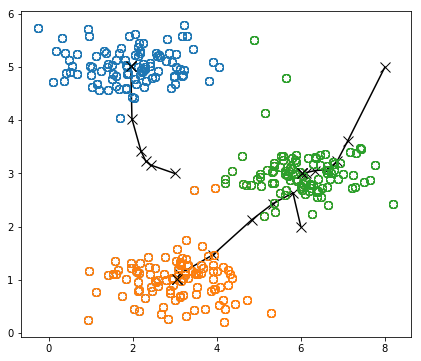

In [9]:
# load data sample
data = loadmat('ex7data2.mat')
X = data['X']

# K-means parameters
K = 3
max_iters = 10
init_c = np.array([[3, 3], [6, 2], [8, 5]])

# run K-means
centroids, idx = runKmeans(X, init_c, max_iters, True)



### 1.3 Random initialization

In practice, a good strategy for initializing the centroids is to select random examples from the training set.b

In [10]:
def kMeansInitCentroids(X, K):
    """ returns K initial centroids to be
%   used with the K-Means on the dataset X
    """
    
    # randomly reorder the indices of the training samples
    rand_idx = np.random.permutation(X.shape[0])
    
    # take first K samples
    return X[rand_idx[:K], :]

### 1.4 Image compression with K-means

In this exercise, you will apply K-means to image compression. In a straightforward 24-bit color representation of an image,2 each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors. 

By making this reduction, it is possible to represent (compress) the photo in an effcient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only
store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In this exercise, you will treat every pixel in the original image as a data example and use the K-means algorithm to find the 16 colors that best group (cluster) the pixels in the 3-dimensional RGB space. Once you have computed the cluster centroids on the image, you will then use the 16 colors to replace the pixels in the original image.

(-0.5, 127.5, 127.5, -0.5)

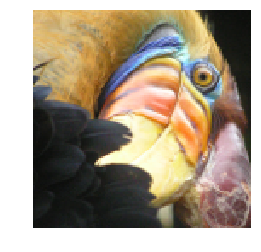

In [11]:
# read image
A = plt.imread('bird_small.png')
fig = plt.imshow(A)
plt.axis('off')

Text(0.5,1,'After')

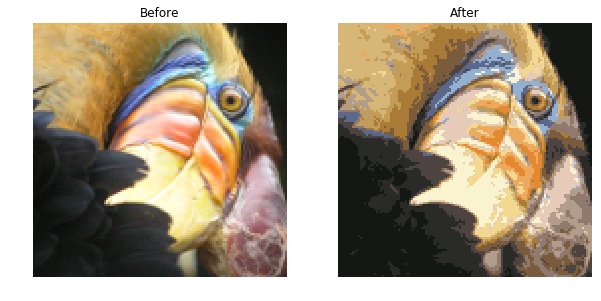

In [12]:
# load data sample
# X is 128 x 128 x 3, reshape to 16384 x 3
X = A.reshape((A.shape[0]*A.shape[1], A.shape[2]))

# K-means parameters
K = 16
max_iters = 10
init_c = kMeansInitCentroids(X, K)

# run K-means
centroids, idx = runKmeans(X, init_c, max_iters, False)

# assign pixel color to corresponding centroid's color
result = np.zeros(X.shape)
for i in range(K):
    result[idx==i, :] = centroids[i, :]

# reshape to 128 x 128 x 3 to plot
result = result.reshape(A.shape)

# show image
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(A)
axes[0].axis('off')
axes[0].set_title('Before')
axes[1].imshow(result)
axes[1].axis('off')
axes[1].set_title('After')

In [13]:
# save compressed file to compare size with original file
plt.imsave('bird_small_compressed.png', result)

# compare size
print('Before compression: {} bytes'.format(os.stat('bird_small.png').st_size))
print('After compression: {} bytes'.format(os.stat('bird_small_compressed.png').st_size))

Before compression: 33031 bytes
After compression: 10709 bytes


### 1.5 Test my own image

(-0.5, 406.5, 336.5, -0.5)

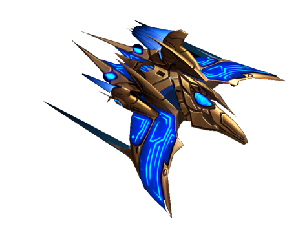

In [14]:
### try my own image
# read image
A = plt.imread('phoenix.png')
fig = plt.imshow(A)
plt.axis('off')

In [15]:
def kMeansInitCentroids2(X, K):
    """ returns K initial centroids to be
%   used with the K-Means on the dataset X
    """
    
    # randomly reorder the indices of the training samples
    rand_idx = np.random.permutation(X.shape[0])
    
    # cherry-pick samples as initial centroids in order to address
    # images with large single color background
    result = np.zeros((K, X.shape[1]))
    
    cnt = 0
    i = 0
    while cnt < K:
        # only pick samples that are not in result already
        if X[rand_idx[i], :] not in result:
            result[cnt, :] = X[rand_idx[i], :]
            cnt += 1
        i += 1
    
    
    return result

Text(0.5,1,'After')

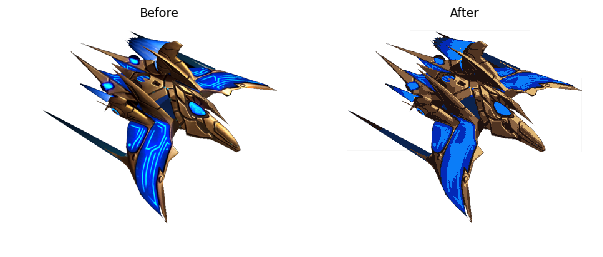

In [16]:
# load data sample
# X is M x N x 4, reshape to (MN) x 4
X = A.reshape((A.shape[0]*A.shape[1], A.shape[2]))

# K-means parameters
K = 16
max_iters = 10
init_c = kMeansInitCentroids2(X, K)

# run K-means
centroids, idx = runKmeans(X, init_c, max_iters, False)

# assign pixel color to corresponding centroid's color
result = np.zeros(X.shape)
for i in range(K):
    result[idx==i, :] = centroids[i, :]

# reshape to M x N x 4 to plot
result = result.reshape(A.shape)

# show image
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(A)
axes[0].axis('off')
axes[0].set_title('Before')
axes[1].imshow(result)
axes[1].axis('off')
axes[1].set_title('After')

In [17]:
# save compressed file to compare size with original file
plt.imsave('phoenix_compressed.png', result)

# compare size
print('Before compression: {} bytes'.format(os.stat('phoenix.png').st_size))
print('After compression: {} bytes'.format(os.stat('phoenix_compressed.png').st_size))

Before compression: 95806 bytes
After compression: 22302 bytes


## 2 Principal Component Analysis

In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction.

### 2.1 Visualizing Example Dataset



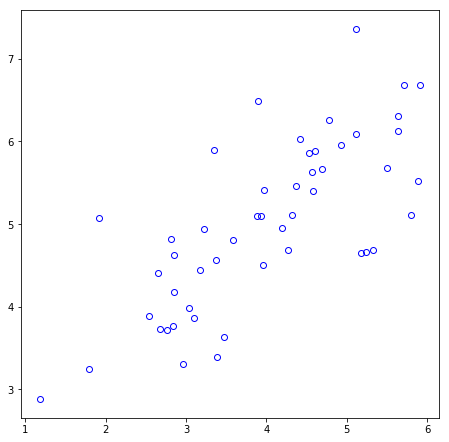

In [18]:
data = loadmat('ex7data1.mat')

X = data['X']

# plot
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.plot(X[:, 0], X[:, 1], 'bo', fillstyle='none')


### 2.2 Implementing PCA
PCA consists of two computational steps: 

First, you compute the covariance matrix of the data. 

$$\Sigma=\frac{1}{m}X^TX$$

Then, compute the eigenvectors $U_1, U_2,..., U_n$.

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range. 

In [19]:
def featureNormalize(X):
    """ returns a normalized version of X where
%   the mean value of each feature is 0 and the standard deviation
%   is 1. 
    """
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

In [24]:
def runPCA(X):
    """ Run principal component analysis on the dataset X, 
    Returns the eigenvectors U, the eigenvalues (on diagonal) S
    """
    
    m = X.shape[0]
    
    # compute covariance matrix
    Sigma = (X.T @ X) / m
    
    # singular value decomposition
    u, s, vh = np.linalg.svd(Sigma)
    
    return u, s

In [25]:
# main codes
X_norm, mu, sigma = featureNormalize(X)

U, S = runPCA(X_norm)

In [27]:
U

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])